# Sea Level Magnitude     
 
```{glue:figure} trend_fig
:scale: 25%
:align: right
```
In this notebook, we'll be creating a [table](SL_magnitude_results), a [map](fig-mag), and a time series [plot](trend_fig) of absolute and regional sea level change at Hawaiian Islands tide gauge stations from 1993-2022. Absolute sea level, typically measured by satellite altimetry, refers to the height of the sea surface relative to a reference ellipsoid. Here, we'll use the global ocean gridded L4 Sea Level Anomalies (SLA) available from Copernicus {cite:t}`cls_france_global_nodate`, which is the sea surface height (SSH) minus the mean sea surface (MSS), where the MSS is the temporal mean of SSH over a given period. Relative sea level is measured by a tide gauge, and is the sea level relative to land at that location. Differences between the two measurements can arise from vertical land motion, regional oceanographic conditions like currents, and changes to the gravitational field (affecting the geoid). 

Download Files:
[Map](../output/SL_magnitude_map.png) |
[Time Series Plot](../output/SL_magnitude_timeseries.png) |
[Table](../output/SL_magnitude_results.csv)

## Setup

We'll run our initial setup for libraries, plotting, and directories.

In [1]:
%run ../setup.ipynb  
data_dir = Path('../../data' )
output_dir = Path('../../output') 

## Retrieve Data Sources

Please see the Data Wrangling notebook, where we source everything from UHSLC and CMEMS. In this notebook, we saved three xarray datasets: a sea level altimetry product for the area around the Hawaiian Islands (asl_hawaii.nc), an hourly tide gauge record for the stations in that region (rsl_hawaii.nc), and a de-meaned daily average tide gauge record (rsl_daily_hawaii.nc).


In [2]:
# Next, let's establish a period of record from 1993-2022.
# establish the time period of interest
start_date = dt.datetime(1993,1,1)
end_date = dt.datetime(2022,12,31)

# Normalize the data relative to the 1993-2012 epoch
epoch_start, epoch_end = start_date, '2012-01-01'
#
# also save them as strings, for plotting
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

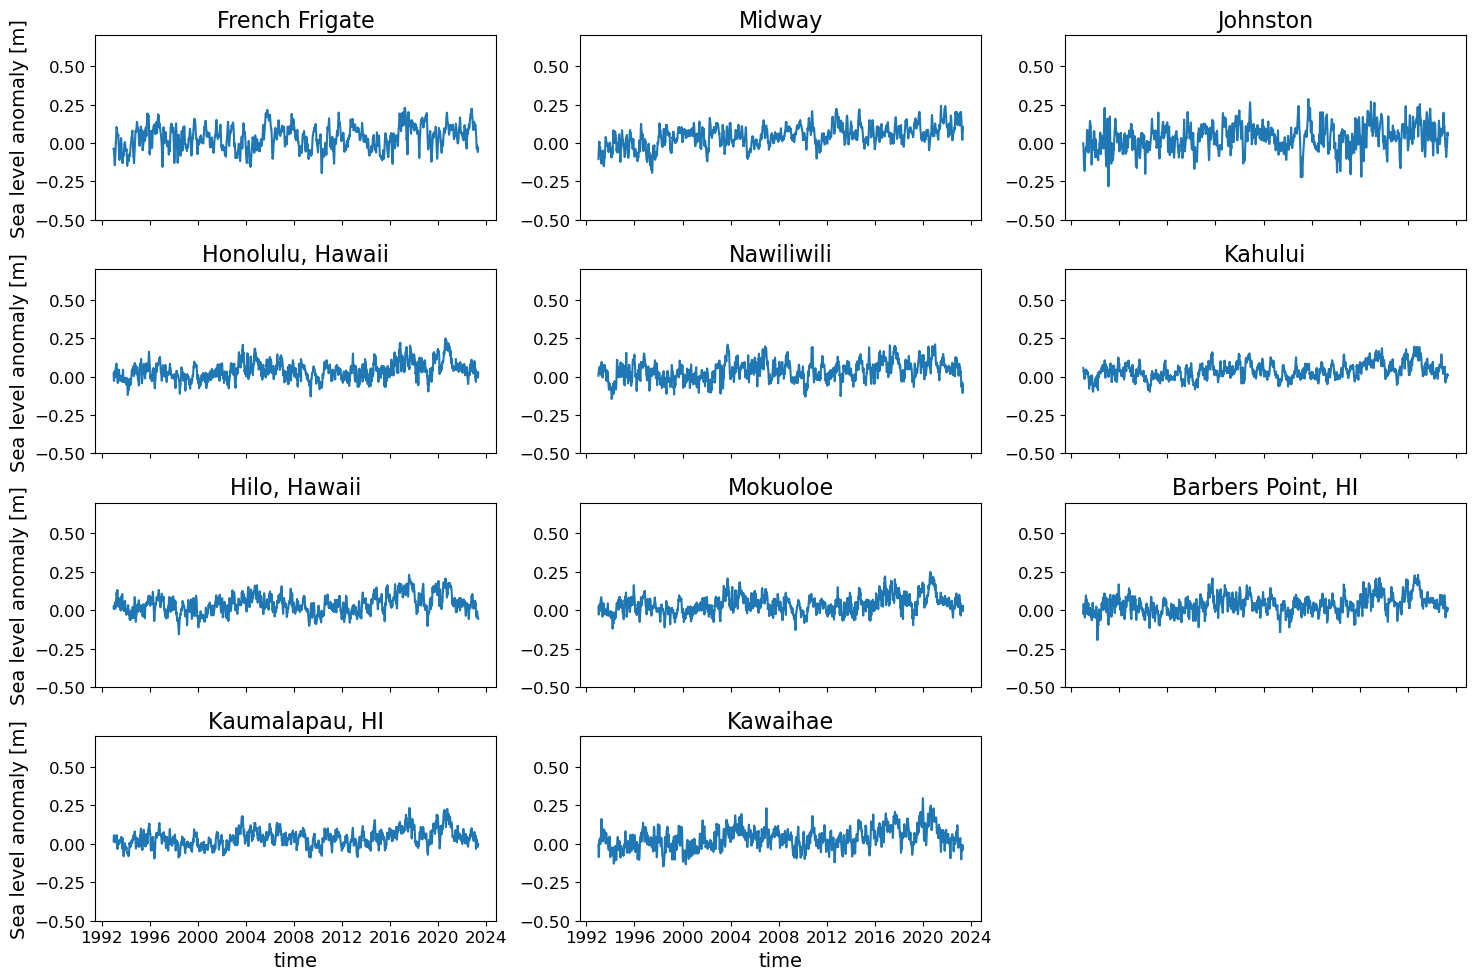

In [3]:
#import datasets
rsl_daily = xr.open_dataset(data_dir / 'rsl_daily_hawaii.nc')
rsl = xr.open_dataset(data_dir / 'rsl_hawaii.nc')
sla_tg = xr.open_dataset(data_dir / 'asl_hawaii.nc')
sla = xr.open_dataset(data_dir / 'cmems_L4_SSH_0.25deg_1993_2023.nc')

g = sla_tg.sla.plot(x='time', col='record_id', col_wrap=3, sharey=False, sharex=True, figsize=(15, 10))

# Use g.axs to iterate over the axes in the FacetGrid
for ax, rid in zip(g.axs.flat, sla_tg.record_id):
    # Accessing the station_name coordinate for the current record_id directly
    station_name = sla_tg.station_name.sel(record_id=rid).item()
    ax.set_title(station_name)
    ax.set_ylim(-0.5, 0.7)

plt.show()


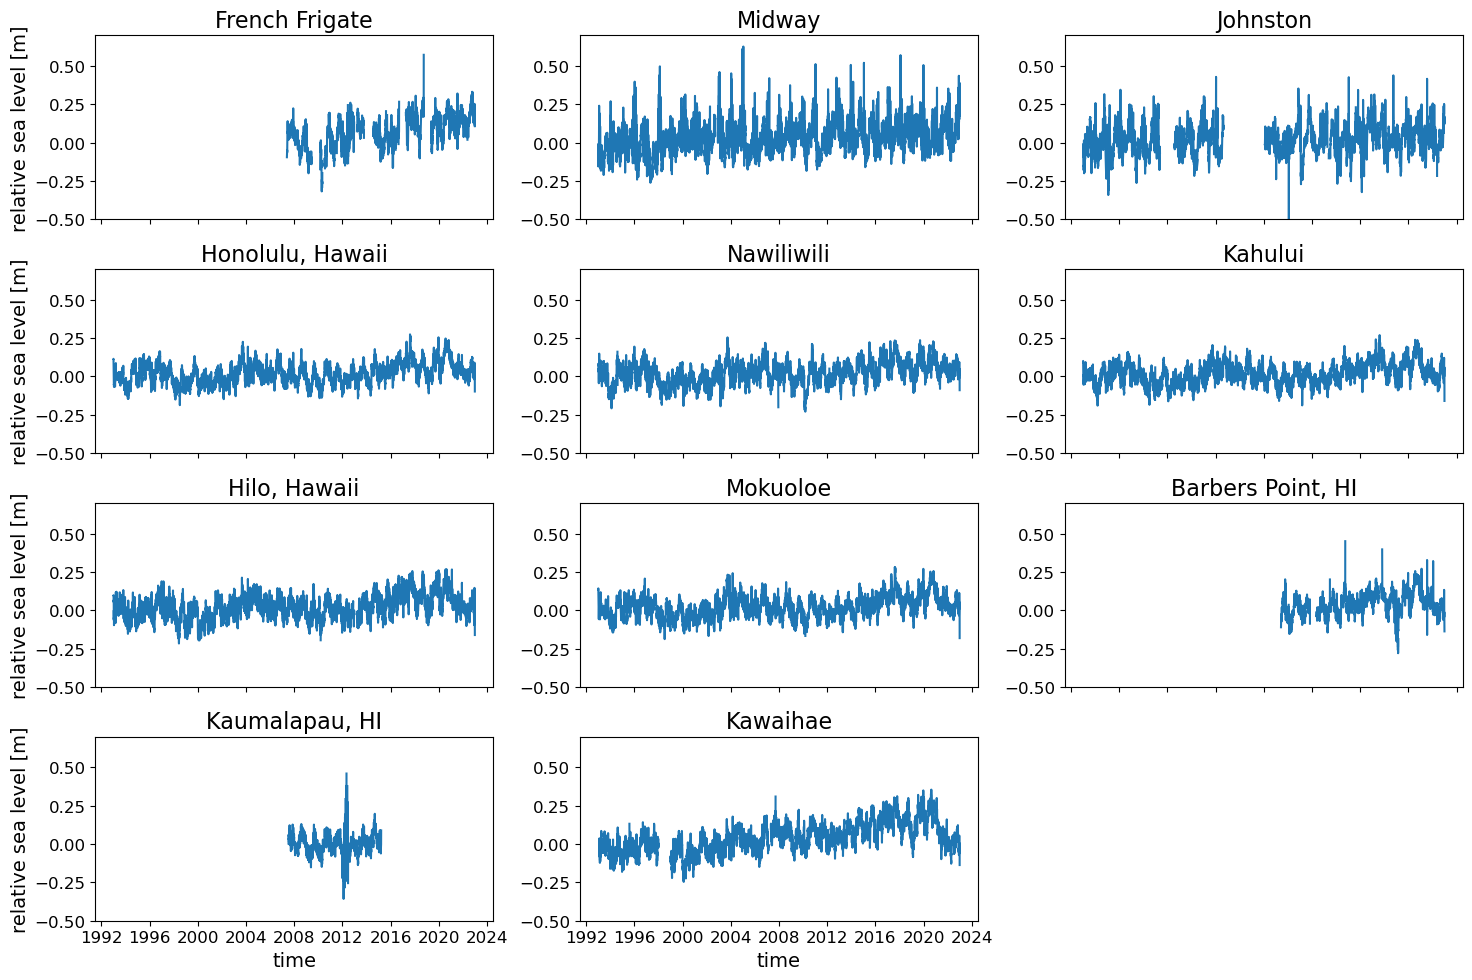

In [4]:
g = rsl_daily.sea_level.plot(x='time', col='record_id', col_wrap=3, sharey=False, sharex=True, figsize=(15, 10))

# Use g.axs to iterate over the axes in the FacetGrid
for ax, rid in zip(g.axs.flat, rsl_daily.record_id):
    # Accessing the station_name coordinate for the current record_id directly
    station_name = rsl_daily.station_name.sel(record_id=rid).item()
    ax.set_title(station_name)
    ax.set_ylim(-0.5, 0.7)

plt.show()

How many nan values are there in rsl['sea_level']?


In [5]:
# first we'll truncate the data to the period of record
sla_epoch = sla_tg.sel(time=slice(epoch_start, epoch_end))

# #print('Number of NaN values in the tide gauge data: ', tide_gauge_data_POR.isnull().sum().values)
#Run a quick check to see if the Ab SL from CMEMS is in fact zeroed about the 1993-2012 epoch. Curse the details.
# Extract the data for the period of record (POR)
#check if the mean is zero
print('The mean for the [1993,2012] epoch of the SLA is', sla_epoch.sla.mean(dim='time', skipna=True).values, 'm. Re-check source data to make sure this is correct.')

The mean for the [1993,2012] epoch of the SLA is [0.02338939 0.02242252 0.02665729 0.02673529 0.02434594 0.02427523
 0.02620254 0.02673529 0.02515467 0.02468215 0.02189661] m. Re-check source data to make sure this is correct.


```{margin}
OLD NOTE FROM PALAU, UPDATE TO HI:
It should be noted that the coordinates from https://ccar.colorado.edu/altimetry/ for the altimetry product are: Lat: 7.2500°N, Lon: 134.4167°E, using https://podaac.jpl.nasa.gov/dataset/SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL1812 as their data source. This data is gridded at 1/6th of a degree as supposed to 1/4th of a degree in the source we are using.
```


Let's make a map to determine exactly where these points are in space. First we'll define a function to prettify the map, which we'll use for the rest of the notebook.


In [6]:
def add_zebra_frame(ax, lw=2, segment_length=0.5, crs=ccrs.PlateCarree()):
    # Get the current extent of the map
    left, right, bot, top = ax.get_extent(crs=crs)

    # Calculate the nearest 0 or 0.5 degree mark within the current extent
    left_start = left - left % segment_length
    bot_start = bot - bot % segment_length

    # Adjust the start if it does not align with the desired segment start
    if left % segment_length >= segment_length / 2:
        left_start += segment_length
    if bot % segment_length >= segment_length / 2:
        bot_start += segment_length

    # Extend the frame slightly beyond the map extent to ensure full coverage
    right_end = right + (segment_length - right % segment_length)
    top_end = top + (segment_length - top % segment_length)

    # Calculate the number of segments needed for each side
    num_segments_x = int(np.ceil((right_end - left_start) / segment_length))
    num_segments_y = int(np.ceil((top_end - bot_start) / segment_length))

    # Draw horizontal stripes at the top and bottom
    for i in range(num_segments_x):
        color = 'black' if (left_start + i * segment_length) % (2 * segment_length) == 0 else 'white'
        start_x = left_start + i * segment_length
        end_x = start_x + segment_length
        ax.hlines([bot, top], start_x, end_x, colors=color, linewidth=lw, transform=crs)

    # Draw vertical stripes on the left and right
    for j in range(num_segments_y):
        color = 'black' if (bot_start + j * segment_length) % (2 * segment_length) == 0 else 'white'
        start_y = bot_start + j * segment_length
        end_y = start_y + segment_length
        ax.vlines([left, right], start_y, end_y, colors=color, linewidth=lw, transform=crs)

/opt/anaconda3/envs/SLI39/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


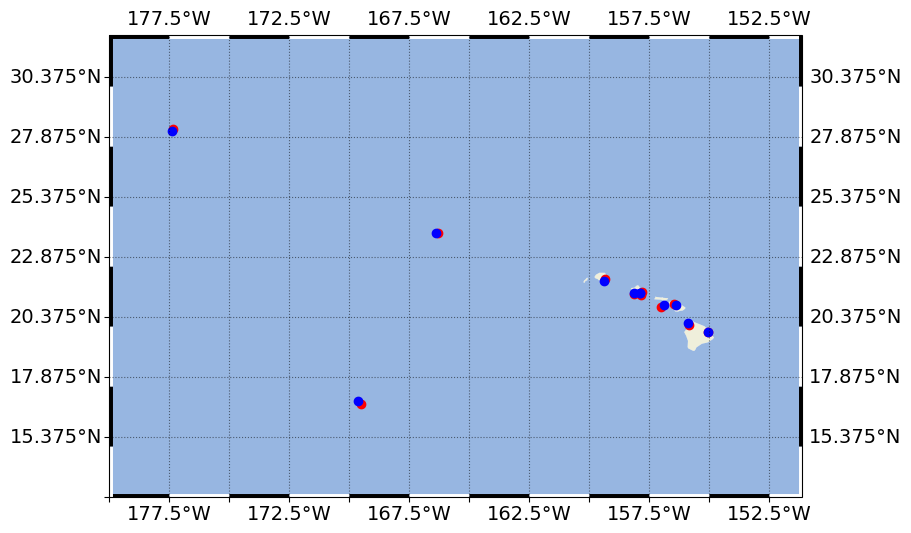

In [7]:
# Set up the map projection
crs = ccrs.PlateCarree()

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10,6), subplot_kw={'projection': crs})
# Set map limits

##get min and max longitude and latitude from sla
minlon = sla.longitude.min().values
maxlon = sla.longitude.max().values
minlat = sla.latitude.min().values
maxlat = sla.latitude.max().values
#
xmin, xmax, ymin, ymax = minlon-2,maxlon+2,minlat-2,maxlat+2

if xmin<-180:
    xmin = -180


#ax.set_xlim([xmin, xmax])
#ax.set_ylim([ymin, ymax])

ax.set_extent([-180, xmax, ymin, ymax], crs=crs)

#
## add the land and ocean features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
#
# Add the tide gauge location
ax.scatter(rsl['lon'], rsl['lat'], marker='o', color='red', transform=crs)

# Add the altimetry grid point
ax.scatter(sla_tg.longitude-360, sla_tg.latitude, marker='o', 
        color='blue', transform=crs)

# Create 2D arrays of the longitude and latitude values
#lon2d, lat2d = np.meshgrid(ds['sla'].longitude, ds['sla'].latitude)

# plot the latitude and longitude values
#ax.scatter(lon2d, lat2d, transform=crs)

# Set custom ticks for the zebra frame
degree_interval = 2.5
ax.set_xticks(np.arange(xmin,xmax,degree_interval), crs=crs)
ax.set_yticks(np.arange(ymin,ymax,degree_interval), crs=crs)
ax.set_xticklabels([]), ax.set_yticklabels([])

# Call the function to add the zebra frame
add_zebra_frame(ax, lw=5, segment_length=2.5, crs=crs)

# add map grid
gl = ax.gridlines(draw_labels=True, linestyle=':', color='black',
                  alpha=0.5,xlocs=ax.get_xticks(),ylocs=ax.get_yticks())

# Add the tide gauge location with callout text
#tide_gauge_label = "Tide Gauge"
#ax.text(rsl['lon']+0.05, rsl['lat']-0.05, tide_gauge_label, 
#        transform=crs, ha='left',va = 'top', fontsize=12)
#
# Add the altimetry grid point with callout text
#altimetry_label = "Nearest Altimetry \n Grid Point"
#ax.text(sla_nearest_lon, sla_nearest_lat+0.05, altimetry_label, 
#        transform=crs, ha='center', va = 'bottom', fontsize=12)

### Plot the timeseries
Here, we'll plot the time series of the altimetry data at the nearest location to the tide gauge (aka 'sla_tg'). The units of sla_tg are in meters, so we'll multiply by 100 to plot in centimeters.


Text(0.5, 1.0, 'Altimetry (1993-2023)')

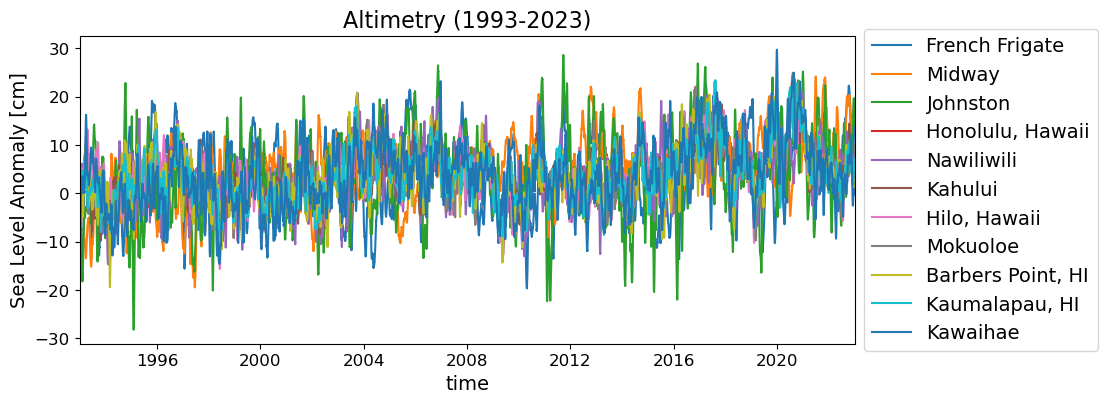

In [8]:
#make a new variable in sla_tg for cm instead of m
sla_tg['sla_cm'] = sla_tg['sla']*100
sla_tg['sla_cm'].attrs['units'] = 'cm'
sla_tg['sla_cm'].attrs['long_name'] = 'Sea Level Anomaly'

#plot the timeseries in sla_tg

sla_tg['sla_cm'].plot.line(x='time',label=sla_tg.station_name.values)

#put the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# set xlimits
plt.xlim([start_date, end_date])

# set title 
plt.title('Altimetry (1993-2023)')

### Calculate change
Now we have all of our data sources, we'll calculate the absolute and relative sea level change (magnitude in cm) at this location for the Period of Record (1993-2022).

To do this, we'll first define a function that calculates the sea level change magnitude.

In [9]:

def process_trend_with_nan(sea_level_anomaly):
    # Flatten the data and get a time index
    # first ensure time is the first dimension regardless of other dimensions
    sea_level_anomaly = sea_level_anomaly.transpose('time', ...)
    sla_flat = sea_level_anomaly.values.reshape(sea_level_anomaly.shape[0], -1)
    time_index = pd.to_datetime(sea_level_anomaly.time.values).to_julian_date()

    detrended_flat = np.full_like(sla_flat, fill_value=np.nan)

    # Loop over each grid point
    for i in range(sla_flat.shape[1]):
        # Get the time series for this grid point
        y = sla_flat[:,i]
        mask = ~np.isnan(y)

        if np.any(mask):
            time_masked = time_index[mask]
            y_masked = y[mask]

            slope, intercept, _, _, _ = stats.linregress(time_masked, y_masked)
            trend = slope * time_index + intercept

            detrended_flat[:,i] = y - trend

    detrended = detrended_flat.reshape(sea_level_anomaly.shape)

    # Calculate trend magnitude
    sea_level_trend = sea_level_anomaly - detrended
    trend_mag = sea_level_trend[-1] - sea_level_trend[0]

    times = pd.to_datetime(sea_level_anomaly['time'].values)
    time_mag = (times[-1] - times[0]).days/365.25 # in years

    trend_rate = trend_mag / time_mag

    return trend_mag, sea_level_trend, trend_rate  


Now we'll run that function for every grid point in our dataset, and make special variables for our proxy tide gauge location.


In [10]:
trend_mag_cmems, trend_line_cmems, trend_rate_cmems = process_trend_with_nan(sla.sla)
trend_mag_asl, trend_line_asl, trend_rate_asl = process_trend_with_nan(sla_tg.sla)


Calculate the weighted mean for the region of interest. 

In [11]:
# calculate the area weights as cosine of latitude
# For a rectangular grid, this is equivalent to multiplying by the grid cell area
weights = np.cos(np.deg2rad(sla.latitude))
weights.name = "weights"

# apply weights to the trend data
trend_mag_weighted = trend_mag_cmems.weighted(weights)

# calculate the regional mean
trend_mag_regional = trend_mag_weighted.mean(dim=('latitude', 'longitude'))

# prepare the output string
output = (
    'The regional magnitude of sea level change is {:.2f} cm for the time '
    'period bounded by {} and {}.'
).format(100*trend_mag_regional.values, start_date_str, end_date_str)

print(output)

The regional magnitude of sea level change is 7.39 cm for the time period bounded by 1993-01-01 and 2022-12-31.


### Plot a map
Plot the Results – MAP

In [12]:
def plot_map(vmin, vmax, xlims, ylims):
    """
    Plot a map of the magnitude of sea level change.

    Parameters:
    vmin (float): Minimum value for the color scale.
    vmax (float): Maximum value for the color scale.
    xlims (tuple): Tuple of min and max values for the x-axis limits.
    ylims (tuple): Tuple of min and max values for the y-axis limits.

    Returns:
    fig (matplotlib.figure.Figure): The matplotlib figure object.
    ax (matplotlib.axes._subplots.AxesSubplot): The matplotlib axes object.
    crs (cartopy.crs.Projection): The cartopy projection object.
    cmap (matplotlib.colors.Colormap): The colormap used for the plot.
    """
    crs = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': crs})
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)

    palette = sns.color_palette("viridis", as_cmap=True)
    cmap = palette

    ax.coastlines()
    ax.add_feature(cfeature.LAND, color='lightgrey')

    return fig, ax, crs, cmap

In [13]:
def plot_zebra_frame(ax, lw=5, segment_length=2, crs=ccrs.PlateCarree()):
    """
    Plot a zebra frame on the given axes.

    Parameters:
    - ax: The axes object on which to plot the zebra frame.
    - lw: The line width of the zebra frame. Default is 5.
    - segment_length: The length of each segment in the zebra frame. Default is 2.
    - crs: The coordinate reference system of the axes. Default is ccrs.PlateCarree().
    """
    # Call the function to add the zebra frame
    add_zebra_frame(ax=ax, lw=lw, segment_length=segment_length, crs=crs)
    # add map grid
    gl = ax.gridlines(draw_labels=True, linestyle=':', color='black',
                      alpha=0.5,xlocs=ax.get_xticks(),ylocs=ax.get_yticks())
    #remove labels from top and right axes
    gl.top_labels = False
    gl.right_labels = False

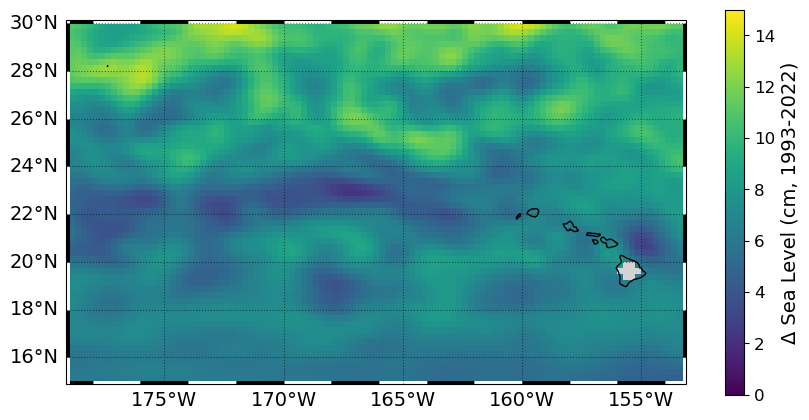

In [14]:
xlims = [minlon, maxlon]
ylims = [minlat,maxlat]
vmin, vmax = 0, 15

fig, ax, crs,cmap = plot_map(vmin,vmax,xlims,ylims)

# plot the trend*100 for centimeters
trend_mag_cmems_cm = trend_mag_cmems * 100

# plot a map of the magnitude of SL change in centimeters
trend_mag_cmems_cm.plot(ax=ax, transform=crs,
                         vmin=vmin, vmax=vmax, cmap=cmap, add_colorbar=True, 
                         cbar_kwargs={'label': 'Δ Sea Level (cm, 1993-2022)'},
)

# Call the function to add the zebra frame
plot_zebra_frame(ax, lw=5, segment_length=2, crs=crs)


(ASLtimeseries)=
### Plot time series
Now we'll plot a time series that includes a trend line, the Absolute Sea Level Change (magnitude in cm) within area/s in proximity to the Tide Station/s. For now, we'll plot only one station at a time. The possible list of stations are:

In [15]:
#make a dataframe with station_name and record_id
df = pd.DataFrame({'station_name':sla_tg.station_name.values, 'record_id':sla_tg.record_id.values})
df

,station_name,record_id
0,French Frigate,140
1,Midway,500
2,Johnston,520
3,"Honolulu, Hawaii",570
4,Nawiliwili,580
5,Kahului,590
6,"Hilo, Hawaii",600
7,Mokuoloe,610
8,"Barbers Point, HI",5470
9,"Kaumalapau, HI",5480


Select which station you'd like to plot here:

In [16]:
# EDIT THIS CELL
recordID = 3

Text(0.95, 0.05, 'Δ Sea Level: 6.38 cm, Trend: 0.21 cm/year')

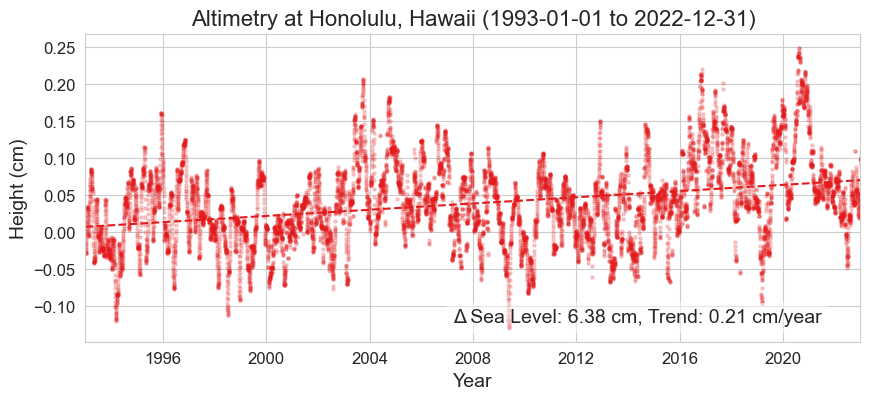

In [17]:
# Set the style of the plot
sns.set_style("whitegrid")

# Create a color palette
palette = sns.color_palette("Set1")

# Plot the timeseries
# Create the figure and the axes
fig, ax = plt.subplots()

# plot altimetry data from sla_tg, using the first record_id


sla_tg.sla.isel(record_id = recordID).plot.scatter(x='time', label='Altimetry', color=palette[0], alpha=0.2, s=5)
trend_line_asl.isel(record_id = recordID).plot.line(x='time', label='Altimetry Trend', color=palette[0], linestyle='--')


# Set the title and labels
title = f"Altimetry at {sla_tg['station_name'].isel(record_id = recordID).values} ({start_date_str} to {end_date_str})"
ax.set_title(title)
ax.set_xlabel('Year')
ax.set_ylabel('Height (cm)')

# Set the x limits
ax.set_xlim([start_date, end_date])

# Add a legend
trendmag_str = (f'Δ Sea Level: {100*trend_mag_asl.isel(record_id=recordID):.2f} cm, '
                f'Trend: {100*trend_rate_asl.isel(record_id=recordID):.2f} cm/year')

# Add text in a white box to bottom right of plot
ax.text(0.95, 0.05, trendmag_str, transform=ax.transAxes, 
        verticalalignment='bottom', horizontalalignment='right', 
        bbox=dict(facecolor='white', alpha=0.5))

### Calculate rate and magnitude of change
Calculate values for both the Trend (rate of change) and Magnitude of Change

In [18]:
rsl_daily

<xarray.Dataset> Size: 571kB
Dimensions:       (record_id: 11, time: 10957)
Coordinates:
  * record_id     (record_id) int16 22B 140 500 520 570 ... 610 5470 5480 5520
  * time          (time) datetime64[ns] 88kB 1993-01-01 ... 2022-12-31
    lat           (record_id) float32 44B ...
    lon           (record_id) float32 44B ...
    station_name  (record_id) <U17 748B ...
Data variables:
    sea_level     (record_id, time) float32 482kB ...

In [19]:
# calculate the rate of change for the tide gauge
trend_mag_rsl, trend_line_rsl, trend_rate_rsl = process_trend_with_nan(rsl_daily.sea_level)

print(f'The trend magnitude for the tide gauge is {100*trend_mag_rsl.isel(record_id=recordID):.2f} cm.')
print(f'The trend rate for the tide gauge is {100*trend_rate_rsl.isel(record_id=recordID):.2f} cm/year.')


The trend magnitude for the tide gauge is 8.09 cm.
The trend rate for the tide gauge is 0.27 cm/year.


(RSLtimeseries)=
### Plot time series
Now we'll combine our daily relative sea level time series, the monthly mean, and a trend line into the same plot. We will label it with the Relative Sea Level Sea Level Change (magnitude in cm) and rate of change (cm/yr) at the Tide Station. The "zero" line is referenced to the [1993,2012] period, following the altimetry. 

/opt/anaconda3/envs/SLI39/lib/python3.9/site-packages/xarray/core/groupby.py:668: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


Text(0.95, 0.05, 'Δ Sea Level: 8.09 cm, Trend: 0.27 cm/year')

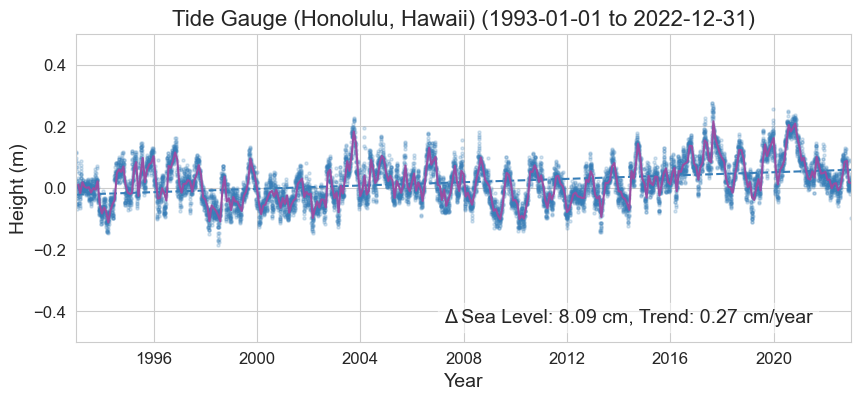

In [20]:
# make an rsl monthly mean for plotting
rsl_monthly = rsl_daily.resample(time='1M').mean().squeeze()

# Set the style of the plot
sns.set_style("whitegrid")

# Create a color palette
palette = sns.color_palette("Set1")

# Plot the timeseries
# Create the figure and the axes
fig, ax = plt.subplots()
# plot data

rsl_daily.sea_level.isel(record_id=recordID).plot.scatter(x='time', label='Tide Gauge', color=palette[1], alpha=0.2, s=5)
trend_line_rsl.isel(record_id=recordID).plot.line(x='time', label='Tide Gauge Trend', color=palette[1], linestyle='--')

# plot the monthly mean sea level
rsl_monthly.sea_level.isel(record_id=recordID).plot.line(x='time', label='Tide Gauge', color=palette[3])


# Set the title and labels
ax.set_title(f'Tide Gauge ({rsl_daily.station_name.isel(record_id=recordID).values}) ({start_date_str} to {end_date_str})')
ax.set_xlabel('Year')
ax.set_ylabel('Height (m)')

# Set the y limits
ax.set_ylim([-.50, .50])

# Set the x limits
ax.set_xlim([start_date, end_date])

# Add a legend
trendmag_str = f'Δ Sea Level: {100*trend_mag_rsl.isel(record_id=recordID):.2f} cm, Trend: {100*trend_rate_rsl.isel(record_id=recordID):.2f} cm/year'
# Add text in a white box to bottom right of plot
ax.text(0.95, 0.05, trendmag_str, transform=ax.transAxes, 
        fontsize=14, verticalalignment='bottom', horizontalalignment='right',
        bbox=dict(facecolor='white', alpha=0.5))

## Combining both sources
(SL_magnitude_results)=
### Create a Table 
That compares the results of sections {numref}`ASLtimeseries` and {numref}`RSLtimeseries`– TABLE


In [21]:

# Constants
DATA_SOURCE_ALTIMETRY = 'CMEMS SSH L4 0.25 deg (SLA)'
DATA_SOURCE_TIDE_GAUGE = 'UHSLC RQDS'
TIME_PERIOD = f'{start_date_str} to {end_date_str}'

# Calculated values 
trend_mmyr_altimetry = 1000 * trend_rate_asl.values
trend_mmyr_tide_gauge = 1000 * trend_rate_rsl.values
delta_sea_level_altimetry = 100 * trend_mag_asl.values
delta_sea_level_tide_gauge = 100 * trend_mag_rsl.values

In [22]:
# Initialize DataFrame with station names and calculate UHSLC_ID directly
SL_magnitude_results = (
    pd.DataFrame({
        'Station_Name': sla_tg.station_name.values,
        'UHSLC_ID': np.int16(rsl_daily['record_id'].values / 10),
        'Trend ASL (mm/yr)': trend_mmyr_altimetry,
        'Trend RSL (mm/yr)': trend_mmyr_tide_gauge,
        'Δ Sea Level ASL (cm)': delta_sea_level_altimetry,
        'Δ Sea Level RSL (cm)': delta_sea_level_tide_gauge,
        'Latitude ASL': sla_tg['latitude'].values,
        'Latitude RSL': rsl_daily['lat'].values,
        'Longitude ASL': sla_tg['longitude'].values,
        'Longitude RSL': rsl_daily['lon'].values,
        'Time_Period': TIME_PERIOD,
        'Data_Source ASL': DATA_SOURCE_ALTIMETRY,
        'Data_Source RSL': DATA_SOURCE_TIDE_GAUGE
    })
)
# if Longitude is greater than 180, subtract 360
SL_magnitude_results['Longitude ASL'] = np.where(SL_magnitude_results['Longitude ASL'] > 180, SL_magnitude_results['Longitude ASL'] - 360, SL_magnitude_results['Longitude ASL'])
SL_magnitude_results['Longitude RSL'] = np.where(SL_magnitude_results['Longitude RSL'] > 180, SL_magnitude_results['Longitude RSL'] - 360, SL_magnitude_results['Longitude RSL'])

SL_magnitude_results




,Station_Name,UHSLC_ID,Trend ASL (mm/yr),Trend RSL (mm/yr),Δ Sea Level ASL (cm),Δ Sea Level RSL (cm),Latitude ASL,Latitude RSL,Longitude ASL,Longitude RSL,Time_Period,Data_Source ASL,Data_Source RSL
0,French Frigate,14,1.871329,NaN,5.674700,NaN,23.875,23.867001,-166.375000,-166.289993,1993-01-01 to 2022-12-31,CMEMS SSH L4 0.25 deg (SLA),UHSLC RQDS
1,Midway,50,4.215143,3.780650,12.782183,11.340399,28.125,28.216999,-177.375000,-177.367004,1993-01-01 to 2022-12-31,CMEMS SSH L4 0.25 deg (SLA),UHSLC RQDS
2,Johnston,52,2.292586,1.802460,6.952137,5.406640,16.875,16.750000,-169.625000,-169.516998,1993-01-01 to 2022-12-31,CMEMS SSH L4 0.25 deg (SLA),UHSLC RQDS
3,"Honolulu, Hawaii",57,2.103058,2.696540,6.377406,8.088512,21.375,21.306999,-157.875000,-157.867004,1993-01-01 to 2022-12-31,CMEMS SSH L4 0.25 deg (SLA),UHSLC RQDS
4,Nawiliwili,58,2.263410,3.062466,6.863662,9.186140,21.875,21.966999,-159.375000,-159.350006,1993-01-01 to 2022-12-31,CMEMS SSH L4 0.25 deg (SLA),UHSLC RQDS
5,Kahului,59,2.105416,2.527900,6.384556,7.582662,20.875,20.900000,-156.375000,-156.466995,1993-01-01 to 2022-12-31,CMEMS SSH L4 0.25 deg (SLA),UHSLC RQDS
6,"Hilo, Hawaii",60,1.975387,3.298495,5.990249,9.894130,19.733,19.733000,-155.067001,-155.067001,1993-01-01 to 2022-12-31,CMEMS SSH L4 0.25 deg (SLA),UHSLC RQDS
7,Mokuoloe,61,2.103058,2.933727,6.377406,8.799976,21.375,21.433001,-157.875000,-157.800003,1993-01-01 to 2022-12-31,CMEMS SSH L4 0.25 deg (SLA),UHSLC RQDS
8,"Barbers Point, HI",547,2.228920,NaN,6.759073,NaN,21.375,21.322001,-158.125000,-158.119995,1993-01-01 to 2022-12-31,CMEMS SSH L4 0.25 deg (SLA),UHSLC RQDS
9,"Kaumalapau, HI",548,2.183053,NaN,6.619986,NaN,20.875,20.783001,-156.875000,-157.000000,1993-01-01 to 2022-12-31,CMEMS SSH L4 0.25 deg (SLA),UHSLC RQDS


In [23]:
# Save to CSV
output_file_path = output_dir / 'SL_magnitude_results.csv'

# Use the path for operations, e.g., saving a DataFrame
SL_magnitude_results.to_csv(output_file_path)

# glue trend_rates to the notebook
glue("trend_rate_rsl", trend_rate_rsl, display=False)
glue("trend_rate_asl", trend_rate_asl, display=False)



### Create a Map 
Now we'll combine a both the tide gauge and altimetry sources into a map that includes the absolute change with the addition of an icon depicting the magnitude of relative change at the tide station.



/opt/anaconda3/envs/SLI39/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1696: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  result = super().scatter(*args, **kwargs)


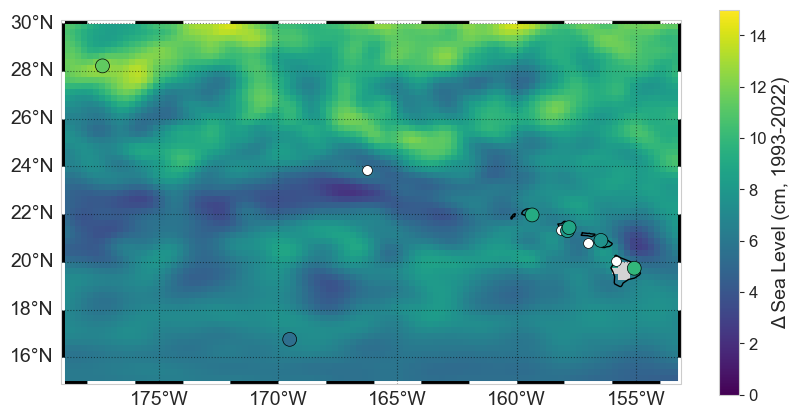

In [24]:
fig, ax, crs,cmap = plot_map(vmin,vmax,xlims,ylims)

# plot the trend*100 for centimeters
trend_mag_cmems_cm = trend_mag_cmems * 100

# plot a map of the magnitude of SL change in centimeters
trend_mag_cmems_cm.plot(ax=ax, transform=crs,
                         vmin=vmin, vmax=vmax, cmap=cmap, add_colorbar=True, 
                         cbar_kwargs={'label': 'Δ Sea Level (cm, 1993-2022)'},
)
ax.scatter(rsl['lon'], rsl['lat'], transform=crs, s=50,
              c='white', vmin=vmin, vmax=vmax, cmap=cmap,
              linewidth=0.5, edgecolor='black',zorder=10)

#remove nan values from trend_mag_rsl
trend_mag_rsl = trend_mag_rsl.where(~np.isnan(trend_mag_rsl),drop = True)

ax.scatter(trend_mag_rsl['lon'], trend_mag_rsl['lat'], transform=crs, s=100, 
           c=100*trend_mag_rsl, vmin=vmin, vmax=vmax, cmap=cmap,
           linewidth=0.5, edgecolor='black',zorder=10)


plot_zebra_frame(ax, lw=5, segment_length=2, crs=crs)

glue("mag_fig", fig, display=False)

# save the figure
output_file_path = output_dir / 'SL_magnitude_map.png'
fig.savefig(output_file_path, dpi=300, bbox_inches='tight')


```{glue:figure} mag_fig
:name: "fig-mag"
Map of absolute and relative sea level change from the altimetry and tide gauge record near {glue:text}`station_group`, {glue:text}`country` station from {glue:text}`startDateTime` to {glue:text}`endDateTime`.
```


### Create a Time series plot 
Finally we will combine both tide gauge and altimetry sources into a time series plot that includes both [Absolute](ASLtimeseries)  and [Relative](RSLtimeseries) Time Series.


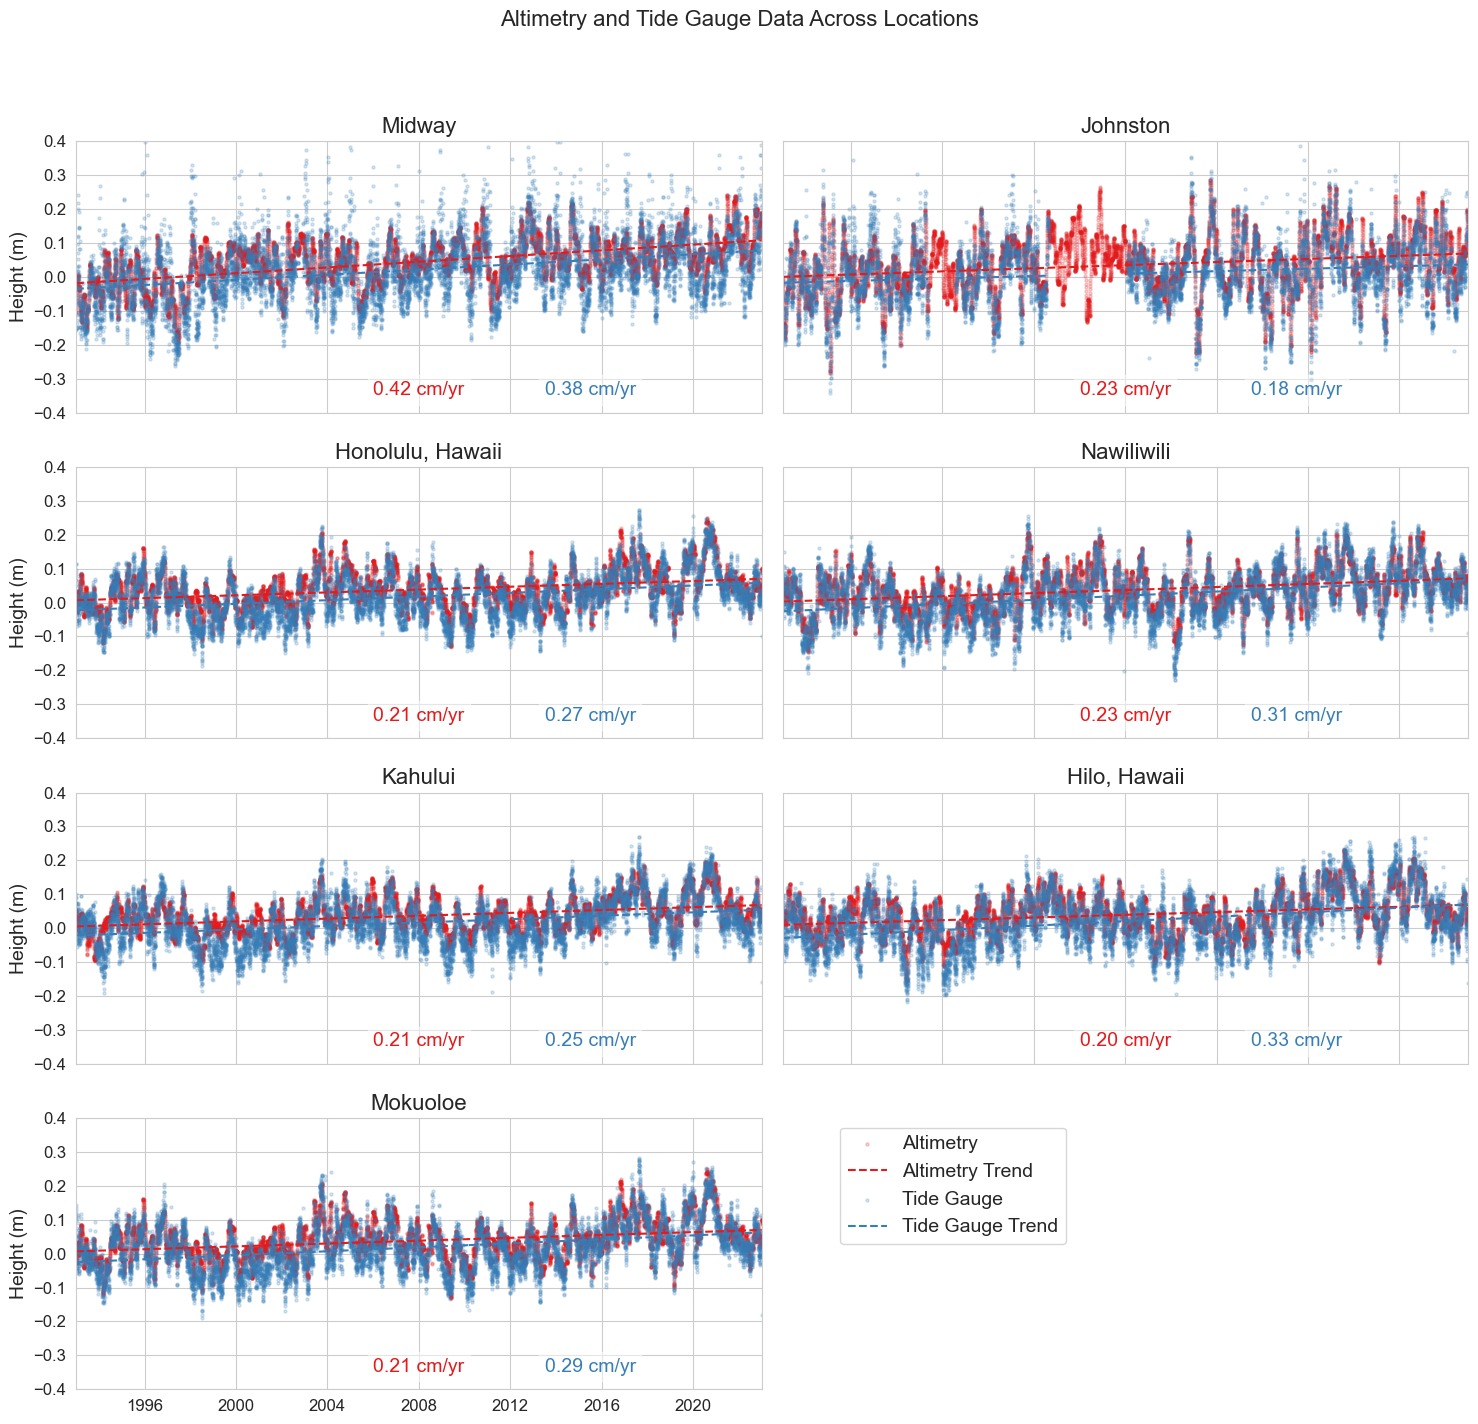

In [25]:
# Set the style of the plot
sns.set_style("whitegrid")

# Create a color palette
palette = sns.color_palette("Set1")



# find the record_ids that do not have nan trend_mag_rsl
record_ids = trend_mag_rsl.record_id.values

fig,axes = plt.subplots(4,2,figsize=(15,15), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(len(record_ids)):
    ax = axes[i]
    # plot altimetry data
    sla_tg.sla.sel(record_id=record_ids[i]).plot.scatter(ax = ax, x='time', label='Altimetry', color=palette[0], alpha=0.2, s=5)
    trend_line_asl.sel(record_id=record_ids[i]).plot.line(ax = ax, x='time', label='Altimetry Trend', color=palette[0], linestyle='--')
    rsl_daily.sea_level.sel(record_id=record_ids[i]).plot.scatter(ax = ax, x='time', label='Tide Gauge', color=palette[1], alpha=0.2, s=5)
    trend_line_rsl.sel(record_id=record_ids[i]).plot.line(ax = ax, x='time', label='Tide Gauge Trend', color=palette[1], linestyle='--')
    title = f'{rsl_daily.station_name.sel(record_id=record_ids[i]).values}'
    ax.set_title(title)
    ax.set_ylabel('Height (m)')

    if i % 2 == 0:
        ax.set_ylabel('Height (m)')
    else:
        ax.set_ylabel('')

    if i < 10:
        ax.set_xlabel('')

    x_pos = 0.5
    y_pos = 0.05
    spacing = 0.25  # Adjust this value as needed for proper spacing

    # Create the first part of the text in red
    ax.text(x_pos, y_pos, f'{100*trend_rate_asl.sel(record_id=record_ids[i]):.2f} cm/yr', color=palette[0],
            verticalalignment='bottom', horizontalalignment='center', transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=0.5))

    # Create the second part of the text in blue, separated by a fixed amount
    ax.text(x_pos + spacing, y_pos, f'{100*trend_rate_rsl.sel(record_id=record_ids[i]):.2f} cm/yr', color=palette[1],
            verticalalignment='bottom', horizontalalignment='center', transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=0.5))
    
    



# Set the y and x limits
ax.set_ylim([-.40, .40])
ax.set_xlim([start_date, end_date])
# Adjust overall figure aesthetics
fig.suptitle('Altimetry and Tide Gauge Data Across Locations', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the main title
# Add a legend in the last subplot
ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.75),ncol = 1)
# remove the last subplot
fig.delaxes(axes[-1])


glue("trend_fig", fig, display=False)

# save the figure
output_file_path = output_dir / 'SL_magnitude_timeseries.png'
fig.savefig(output_file_path, dpi=300, bbox_inches='tight')



```{glue:figure} trend_fig
:name: "trend_fig"

Absolute sea level trend (red) from altimetry, and relative sea level trend (blue) from the tide gauge record at the {glue:text}`station`, {glue:text}`country` station from {glue:text}`startDateTime` to {glue:text}`endDateTime`.
```
---

## Citations

:::{bibliography}
:style: alpha
:filter: docname in docnames
:::